# Các công việc triển khai

Trong file này sẽ thực hiện các việc.

- Cho data ảnh từ các tập train, valid, test qua module 1 và save lại kết quả vào 3 file csv tương ứng.
- Cụ thể với mỗi một ảnh, ảnh gốc sẽ resize về 1024x768, cắt lấy 12 miếng theo lưới 256x256. Như vậy tổng cộng thu được 13 miếng (tất cả resize về 224x224). Cuối cùng 13 miếng này cho qua module 1 thu được 13 vector 3 chiều (tương ứng cho xác suất thuộc về 3 nhãn của 1 miếng ảnh). Như vậy 1 bản ghi sẽ được lưu trữ dưới dạng 13 chiều 3 chiều này (tức 39 chiều).
- Sau khi đã save 3 file csv cho mỗi tập. Thực hiện phân tích phân phối dữ liệu các trường thu được (trước hết chỉ thực hiện với 3 chiều đầu tiên - tức chỉ cho miếng toàn cục nhất). Sau đó mới phân tích đến cả 39 chiều cùng lúc.
- Các thông tin đem phân tích có thể như phân phối của chiều dữ liệu này có phải phân phối chuẩn hay không. Hệ số tương quan của các chiều này với nhau (tại vì chúng có thể có hiện tượng đa cộng tuyến).
- Sau khi xác định được phân phối của dữ liệu thì đề xuất các phương pháp để tạo sinh thêm dữ liệu mới dựa trên dữ liệu phân phối đã có.

/home/haipn/Clone/Research_ThyroidFNA_ClassAI/phase2_280824/notebooks/explore
/home/haipn/Clone/Research_ThyroidFNA_ClassAI/phase2_280824/src/models/module1
Using device: cuda
Processed train dataset. Shape: (1261, 41)
Analyzing dim_0 distribution by label...
Label 2, normality test for dim_0: p-value = 1.0507752508338001e-11


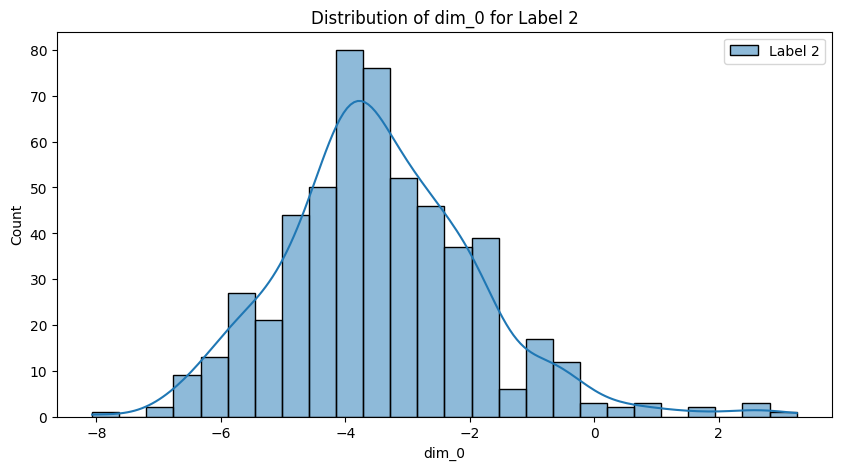

Label 0, normality test for dim_0: p-value = 0.22697288569579527


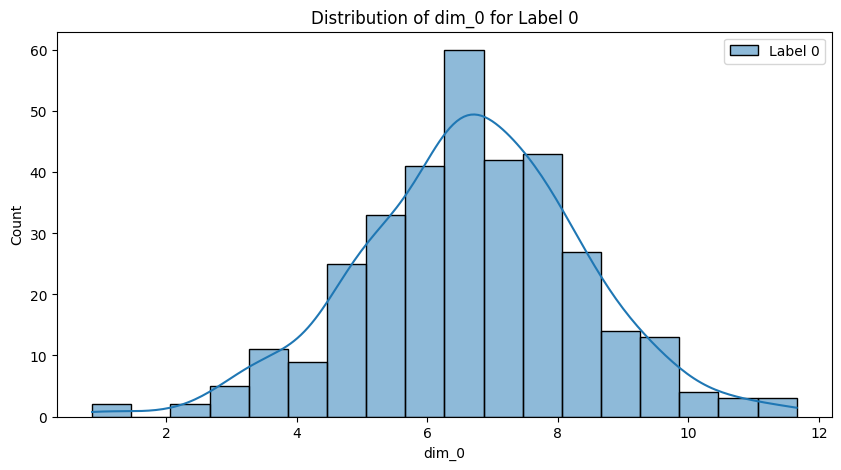

Label 1, normality test for dim_0: p-value = 0.007806199325638924


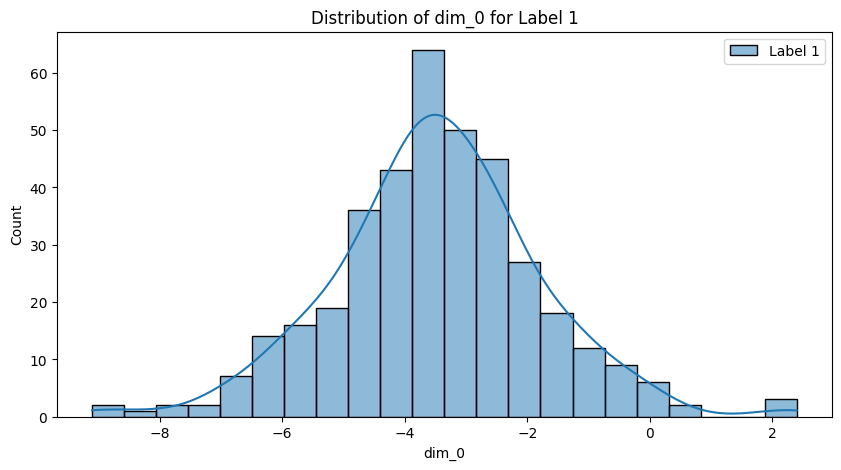

Analyzing dim_1 distribution by label...
Label 2, normality test for dim_1: p-value = 0.0015795239028283277


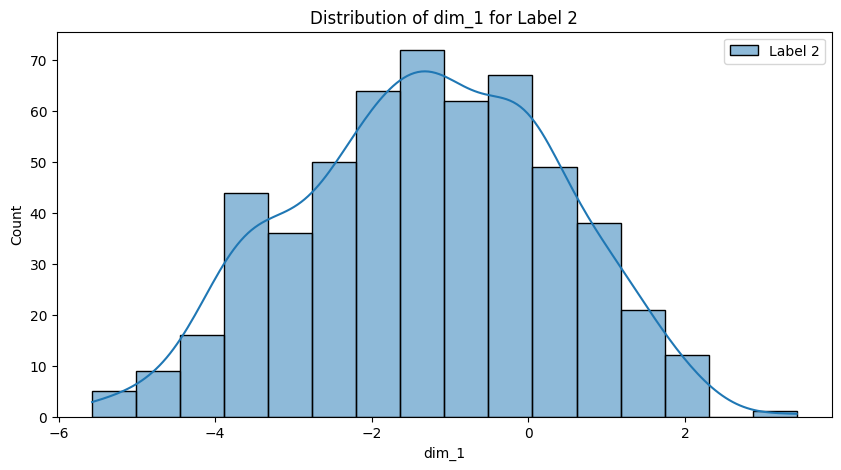

Label 0, normality test for dim_1: p-value = 0.8344045159190209


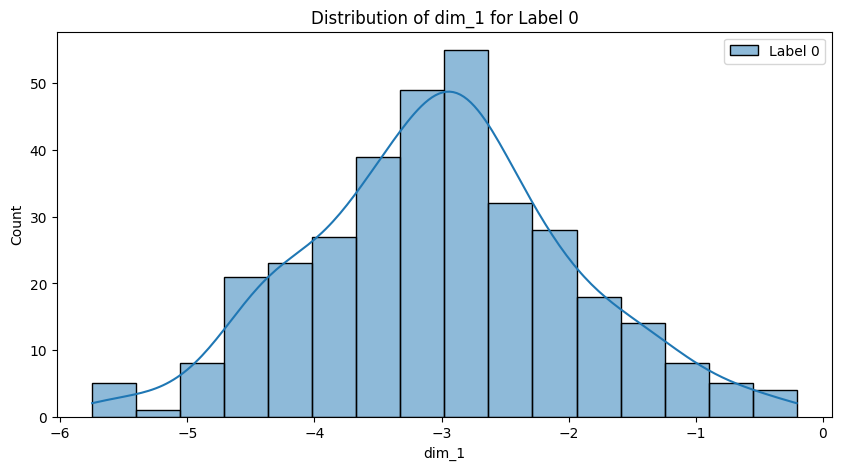

Label 1, normality test for dim_1: p-value = 5.413314415967223e-05


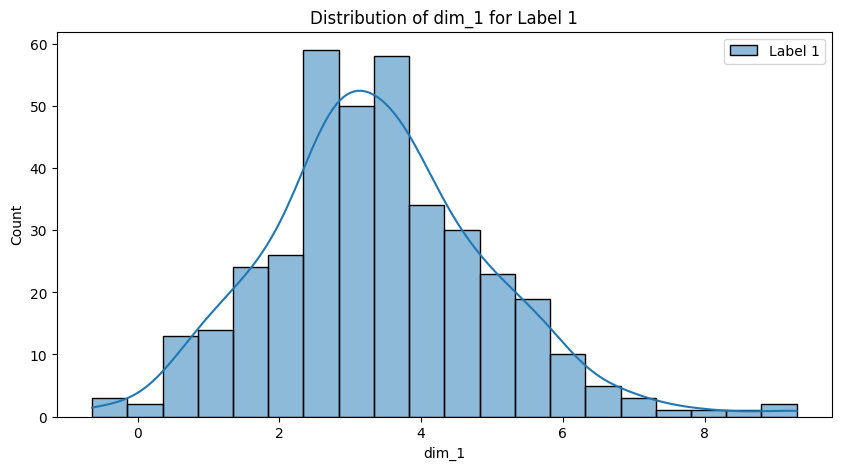

Analyzing dim_2 distribution by label...
Label 2, normality test for dim_2: p-value = 3.80372346852757e-07


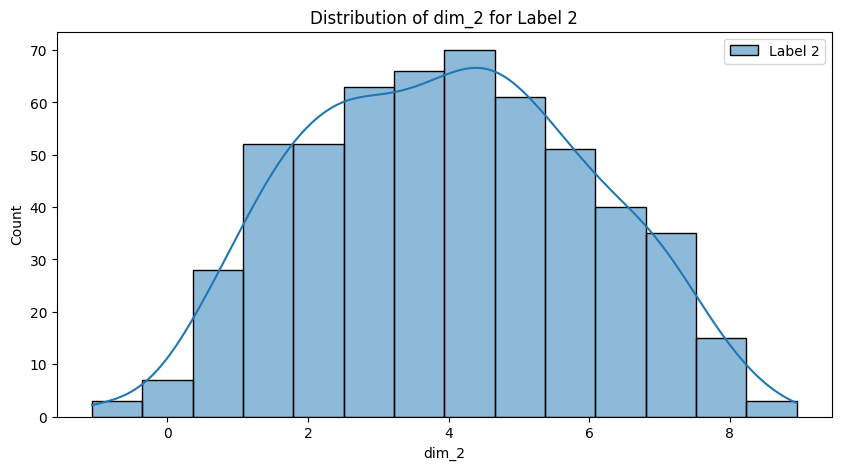

Label 0, normality test for dim_2: p-value = 0.023610593927194112


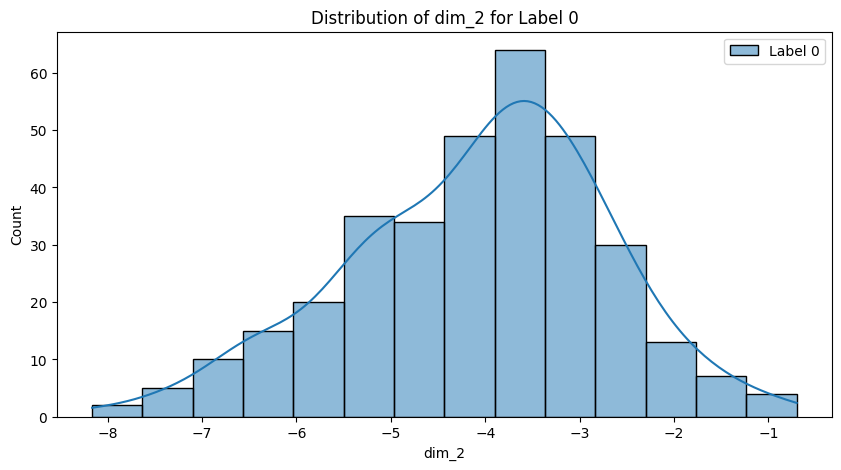

Label 1, normality test for dim_2: p-value = 0.04501969116715383


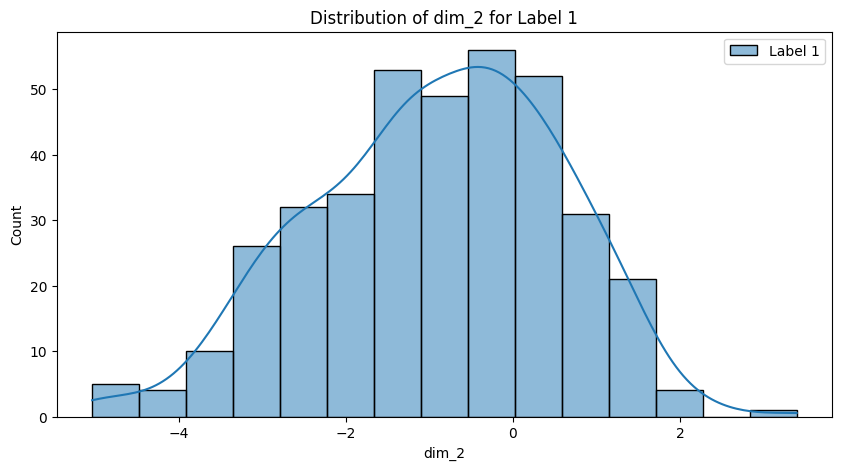

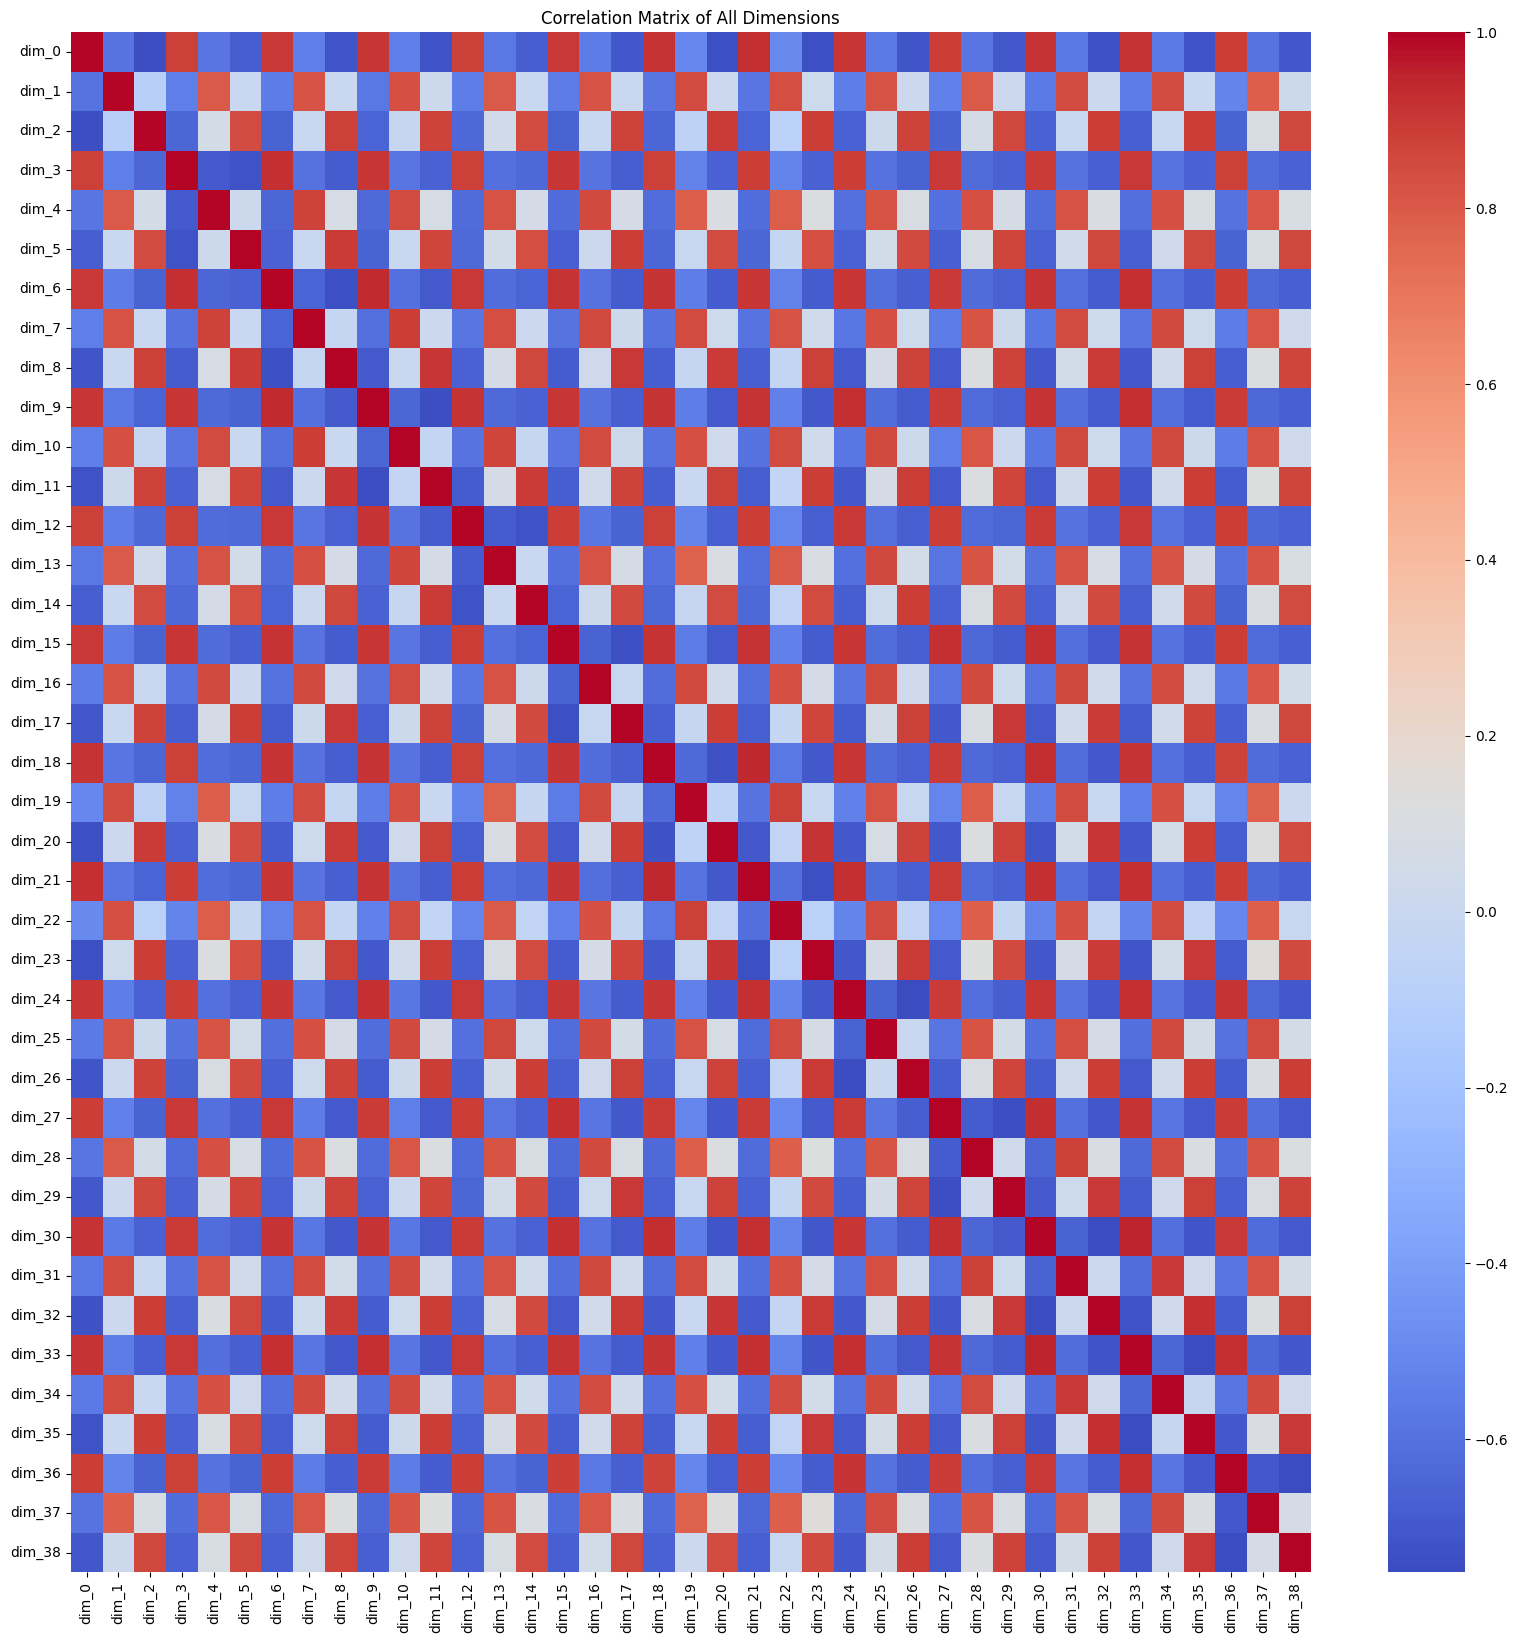

In [ ]:
!pwd
import os
import torch
import torchvision.transforms as transforms
from PIL import Image
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming H0_EfficientNetB0 is imported correctly
os.chdir("../../src/models/module1")
!pwd
from efficient_net import H0_EfficientNetB0

def load_model(model_path):
    model = H0_EfficientNetB0()
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.load_state_dict(torch.load(model_path, weights_only=True, map_location=device), strict=False)
    model.to(device)
    model.eval()
    return model, device

def process_image(image_path, model, device):
    label_map = {'B2': 0, 'B5': 1, 'B6': 2}
    label = label_map.get(image_path.split('/')[-2])
    if label is None:
        raise ValueError(f"Invalid label: {image_path.split('/')[-2]}")
    
    # Resize to 1024x768 and create 12 256x256 patches + 1 full image
    image = Image.open(image_path).convert('RGB')
    image = image.resize((1024, 768))
    patches = [image] + [image.crop((j*256, i*256, (j+1)*256, (i+1)*256)) for i in range(3) for j in range(4)]
    
    # Resize all to 224x224 and process
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    
    # Convert all patches to tensors and stack them into a single batch
    batch_tensor = torch.stack([transform(patch) for patch in patches]).to(device)
    
    # Run the model inference on the entire batch
    with torch.no_grad():
        outputs = model(batch_tensor)
    
    # Flatten the results and extend to the results list
    return label, outputs.cpu().numpy().flatten()

def process_dataset(data_dir, model, device, output_file):
    results = []
    for root, _, files in os.walk(data_dir):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_path = os.path.join(root, file)
                label, result = process_image(image_path, model, device)
                results.append([image_path, label] + result.tolist())
    
    df = pd.DataFrame(results, columns=['image_path', 'label'] + [f'dim_{i}' for i in range(39)])
    df.to_csv(output_file, index=False)
    return df

def analyze_distribution(df):
    # Analyze first 3 dimensions (global patch) per label
    for i in range(3):
        col = f'dim_{i}'
        print(f"Analyzing {col} distribution by label...")
        for label in df['label'].unique():
            subset = df[df['label'] == label][col]
            _, p_value = stats.normaltest(subset)
            print(f"Label {label}, normality test for {col}: p-value = {p_value}")
            
            plt.figure(figsize=(10, 5))
            sns.histplot(subset, kde=True, label=f'Label {label}')
            plt.title(f"Distribution of {col} for Label {label}")
            plt.legend()
            plt.show()
    
    # Correlation matrix for all 39 dimensions
    corr_matrix = df.iloc[:, 2:].corr()  # Start from column 2 to skip image_path and label
    plt.figure(figsize=(20, 20))
    sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
    plt.title("Correlation Matrix of All Dimensions")
    plt.show()

def main():
    # model_path = '../../weights/1725034685_phase2_280824_module1_H0_EfficientNetB0/best_loss.pth'
    model_path = '/home/haipn/Clone/Research_ThyroidFNA_ClassAI/phase2_280824/results/1725034685_phase2_280824_module1_H0_EfficientNetB0/best_loss.pth'
    model, device = load_model(model_path)
    print(f"Using device: {device}")
    
    data_dirs = {
        'train': '../../../data/1725013654_A_set/train',
        'valid': '../../../data/1725013654_A_set/valid',
        'test': '../../../data/1725013654_A_set/test'
    }
    
    for split, data_dir in data_dirs.items():
        output_file = f'../../../data/processed/{split}_features.csv'
        df = process_dataset(data_dir, model, device, output_file)
        print(f"Processed {split} dataset. Shape: {df.shape}")
        
        analyze_distribution(df)
    
    print("Processing and analysis complete.")

if __name__ == "__main__":
    main()